# US Stock Market Overview

In [1]:
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown
import ipywidgets as widgets
from ipywidgets import interactive

In [2]:
%matplotlib inline

# %load_ext pycodestyle_magic
# %flake8_on

In [3]:
yesterday = datetime.today() - timedelta(days=1)

try:
    raw_df = pd.read_csv(f'./db/{yesterday.strftime("%Y-%m-%d")}_raw.csv')
except FileNotFoundError:
    raw_df = pd.read_csv('./db/2021-10-14_raw.csv')

df = raw_df.set_index('No.')  # Set the index to No. column

In [4]:
# Replacing missing data with NaN
for col in df.columns:
    df[col].replace('-', np.nan, inplace=True)

# Price column: Data Cleaning
df['Price'] = df.apply(
    lambda row: np.nan if np.isnan(row['Price']) else float(
        row['Price']
    ),
    axis='columns'
)
# Change column: Data Cleaning
df['Change'] = df.apply(
    lambda row: np.nan if row['Change'] is np.nan else float(
         str(row['Change'])[:-1]
    ),
    axis='columns'
)
# Volume column: Data Cleaning
df['Volume'] = df.apply(
    lambda row: np.nan if row['Volume'] is np.nan else int(
        ''.join(str(row.Volume).split(','))
    ),
    axis='columns'
)
# P/E column: Data Cleaning
df['P/E'] = df.apply(
    lambda row: float(row['P/E']),
    axis='columns'
)


# Market Cap: Data Cleaning
def cap_calc(row):
    s = str(row['Market Cap']).strip()
    if s[-1] == 'M':
        return float(s[:-1])
    elif s[-1] == 'B':
        return float(s[:-1]) * 1000


# Notice that Market Cap is based on $Million.
df['Market Cap'] = df.apply(cap_calc, axis='columns')
# Renaming columns for ease of use
df.rename(
    columns={
        col: '_'.join(col.split()).lower()
        for col in df.columns
    },
    inplace=True
)

## Main DataFrame after cleaning

> Notice that Market Cap is based on million dollars.

In [5]:
df.head(7)

,ticker,company,sector,industry,country,market_cap,p/e,price,change,volume
No.,,,,,,,,,,
1,A,"Agilent Technologies, Inc.",Healthcare,Diagnostics & Research,USA,47060.00,47.54,152.59,1.58,1427339
2,AA,Alcoa Corporation,Basic Materials,Aluminum,USA,9280.00,21.44,48.60,0.41,9198865
3,AAAU,Goldman Sachs Physical Gold ETF,Financial,Exchange Traded Fund,USA,NaN,NaN,17.86,0.25,149479
4,AAC,Ares Acquisition Corporation,Financial,Shell Companies,USA,1220.00,100.62,9.76,0.00,89792
5,AACG,ATA Creativity Global,Consumer Defensive,Education & Training Services,China,71.37,NaN,2.28,0.00,17961
6,AACIU,Armada Acquisition Corp. I Unit,Financial,Shell Companies,USA,NaN,NaN,9.97,0.61,89
7,AADI,"Aadi Bioscience, Inc.",Healthcare,Biotechnology,USA,576.04,NaN,26.78,-1.03,70471


In [6]:
Markdown(f"""
- Market Cap missing {df.isnull().sum().market_cap} rows
    - {
df[df.market_cap.isnull()].sector.value_counts().Financial
} of missing data belong to Financial Sector
        - {
df[df.market_cap.isnull()].industry.value_counts()['Exchange Traded Fund']
} of missing data belong to ETFs in Financial Sector
(None of ETFs have Market Cap)
        - {
df[df.market_cap.isnull()].industry.value_counts()['Shell Companies']
} of missing data belong to Shell Companies in Financial Sector
(Almost 50% of Shell Companies)
        - {
df[df.market_cap.isnull()].sector.value_counts().Financial
- df[df.market_cap.isnull()].industry.value_counts()['Exchange Traded Fund']
- df[df.market_cap.isnull()].industry.value_counts()['Shell Companies']
} of missing data belong to other Industries in Financial Sector
    - {
df.isnull().sum().market_cap
- df[df.market_cap.isnull()].sector.value_counts().Financial
} of missing data belong to other Sectors

> The most missing data from the Market Cap column belongs to ETFs.

Since ETFs are real important part, we can separate our analysis into 2 different parts:
Non ETFs & ETFs
""")


- Market Cap missing 2371 rows
    - 2318 of missing data belong to Financial Sector
        - 2022 of missing data belong to ETFs in Financial Sector
(None of ETFs have Market Cap)
        - 275 of missing data belong to Shell Companies in Financial Sector
(Almost 50% of Shell Companies)
        - 21 of missing data belong to other Industries in Financial Sector
    - 53 of missing data belong to other Sectors

> The most missing data from the Market Cap column belongs to ETFs.

Since ETFs are real important part, we can separate our analysis into 2 different parts:
Non ETFs & ETFs


In [7]:
def stocks_data(data: pd.DataFrame) -> pd.DataFrame:
    df = data[data['industry'] != 'Exchange Traded Fund'].reset_index()
    df.drop(['p/e', 'No.'], axis=1, inplace=True)
    df.dropna(subset=['market_cap'], inplace=True)
    return df

In [8]:
stocks_df = stocks_data(df)

## Stocks DataFrame after droping unnecessary data

In [9]:
stocks_df.head(7)

,ticker,company,sector,industry,country,market_cap,price,change,volume
0,A,"Agilent Technologies, Inc.",Healthcare,Diagnostics & Research,USA,47060.00,152.59,1.58,1427339
1,AA,Alcoa Corporation,Basic Materials,Aluminum,USA,9280.00,48.60,0.41,9198865
2,AAC,Ares Acquisition Corporation,Financial,Shell Companies,USA,1220.00,9.76,0.00,89792
3,AACG,ATA Creativity Global,Consumer Defensive,Education & Training Services,China,71.37,2.28,0.00,17961
5,AADI,"Aadi Bioscience, Inc.",Healthcare,Biotechnology,USA,576.04,26.78,-1.03,70471
6,AAIC,Arlington Asset Investment Corp.,Real Estate,REIT - Mortgage,USA,127.92,3.99,3.10,481507
7,AAL,American Airlines Group Inc.,Industrials,Airlines,USA,12780.00,19.64,0.15,21238031


## Intuition

We need to look at the data and it's descriptive measurements to have some insight with the data we're dealing with.

In [10]:
stocks_df.describe()

,market_cap,price,change,volume
count,5.958000e+03,5958.000000,5958.00000,5.958000e+03
mean,1.131601e+04,120.685126,0.80887,1.276627e+06
std,6.981022e+04,5489.838262,2.66857,5.336197e+06
min,1.300000e-01,0.050000,-39.56000,0.000000e+00
25%,2.438675e+02,7.870000,-0.20000,5.838350e+04
50%,9.355250e+02,17.445000,0.78000,2.288255e+05
75%,4.537500e+03,46.190000,1.99000,8.002978e+05
max,2.382860e+06,423648.000000,39.32000,1.185701e+08


### Let's take a look at correlation matrix:

<AxesSubplot:>

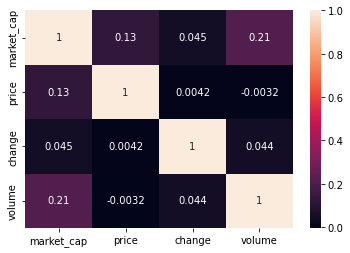

In [11]:
cor_stocks = stocks_df.corr()
sns.heatmap(
    cor_stocks,
    xticklabels=cor_stocks.columns,
    yticklabels=cor_stocks.columns,
    annot=True
)

In [12]:
correlation_set_stocks = set(
    tuple(sorted([col, cor_stocks.columns[ind]]))
    for col in cor_stocks.columns
    for ind in np.where((cor_stocks[col] >= 0.1) & (cor_stocks[col] != 1))[0]
)
Markdown(
    "> It seems there is a little correlation between:\n"
    + '\n'.join([
        '> - **' + col1 + '**' + ', ' + '**' + col2 + '**'
        for col1, col2 in correlation_set_stocks
    ])
)

> It seems there is a little correlation between:
> - **market_cap**, **price**
> - **market_cap**, **volume**

# Top movers

### Most traded stocks

In [13]:
top_movers_stocks = stocks_df.reset_index()

In [14]:
zs_vol = zscore(stocks_df.volume)
volume_outliers = np.where(abs(zs_vol) > 3)[0]
most_traded_stocks = top_movers_stocks.loc[volume_outliers].sort_values(
    by=['volume'],
    ascending=False
).reset_index().drop(['index', 'level_0'], axis=1)

In [15]:
most_traded_stocks.head(10)

,ticker,company,sector,industry,country,market_cap,price,change,volume
0,CEI,"Camber Energy, Inc.",Energy,Oil & Gas E&P,USA,74.24,1.27,-10.56,118570111
1,GRVI,"Grove, Inc.",Healthcare,Drug Manufacturers - Specialty & Generic,USA,107.91,6.98,39.32,118230460
2,BBIG,"Vinco Ventures, Inc.",Consumer Cyclical,Leisure,USA,866.85,8.36,22.76,106433047
3,TLGT,"Teligent, Inc.",Healthcare,Drug Manufacturers - Specialty & Generic,USA,18.85,0.20,-39.56,99524008
4,PROG,"Progenity, Inc.",Healthcare,Biotechnology,USA,312.27,2.09,2.45,92068931
5,FAMI,"Farmmi, Inc.",Consumer Defensive,Packaged Foods,China,104.05,0.34,-3.66,85147974
6,BAC,Bank of America Corporation,Financial,Banks - Diversified,USA,377380.00,45.07,4.47,81854348
7,DATS,"DatChat, Inc.",Technology,Software - Application,USA,141.84,11.99,9.00,79206179
8,PLUG,Plug Power Inc.,Industrials,Electrical Equipment & Parts,USA,17530.00,31.81,-5.30,76566064
9,OCGN,"Ocugen, Inc.",Healthcare,Biotechnology,USA,2000.00,10.05,8.88,72658653


### Most percentage change

In [16]:
zs_change = zscore(stocks_df.change)
change_outliers = np.where(abs(zs_change) > 4)[0]
most_percentage_change_stocks = top_movers_stocks.loc[change_outliers].sort_values(
    by=['change'],
    key=lambda col: abs(col),
    ascending=False
).reset_index().drop(['index', 'level_0'], axis=1)

In [17]:
most_percentage_change_stocks.head(10)

,ticker,company,sector,industry,country,market_cap,price,change,volume
0,TLGT,"Teligent, Inc.",Healthcare,Drug Manufacturers - Specialty & Generic,USA,18.85,0.20,-39.56,99524008
1,GRVI,"Grove, Inc.",Healthcare,Drug Manufacturers - Specialty & Generic,USA,107.91,6.98,39.32,118230460
2,NRXP,"NRx Pharmaceuticals, Inc.",Healthcare,Biotechnology,USA,717.82,11.91,26.17,60095528
3,BWEN,"Broadwind, Inc.",Industrials,Specialty Industrial Machinery,USA,70.00,3.46,25.82,5671535
4,BBIG,"Vinco Ventures, Inc.",Consumer Cyclical,Leisure,USA,866.85,8.36,22.76,106433047
5,TIGR,UP Fintech Holding Limited,Financial,Capital Markets,China,1240.00,8.18,-21.19,42830743
6,XPOF,"Xponential Fitness, Inc.",Consumer Cyclical,Leisure,USA,707.75,16.54,20.82,744935
7,DRIO,DarioHealth Corp.,Healthcare,Diagnostics & Research,USA,275.24,16.20,20.18,773337
8,HBP,"Huttig Building Products, Inc.",Industrials,Industrial Distribution,USA,176.22,6.26,20.15,913921
9,WTRH,Waitr Holdings Inc.,Technology,Software - Application,USA,125.80,1.03,-18.90,35082890


### Most traded and most changed

In [18]:
both_outliers = sorted(list(
    set(volume_outliers).intersection(change_outliers)
))
most_traded_and_most_changed_stocks = top_movers_stocks.loc[both_outliers].sort_values(
    by=['change'],
    ascending=False
).reset_index().drop(['index', 'level_0'], axis=1)

In [19]:
most_traded_and_most_changed_stocks

,ticker,company,sector,industry,country,market_cap,price,change,volume
0,GRVI,"Grove, Inc.",Healthcare,Drug Manufacturers - Specialty & Generic,USA,107.91,6.98,39.32,118230460
1,NRXP,"NRx Pharmaceuticals, Inc.",Healthcare,Biotechnology,USA,717.82,11.91,26.17,60095528
2,BBIG,"Vinco Ventures, Inc.",Consumer Cyclical,Leisure,USA,866.85,8.36,22.76,106433047
3,CETX,"Cemtrex, Inc.",Industrials,Conglomerates,USA,26.31,1.17,13.04,58274262
4,CEI,"Camber Energy, Inc.",Energy,Oil & Gas E&P,USA,74.24,1.27,-10.56,118570111
5,FUTU,Futu Holdings Limited,Financial,Capital Markets,Hong Kong,10730.00,73.81,-12.41,22864998
6,SESN,"Sesen Bio, Inc.",Healthcare,Biotechnology,USA,174.46,0.88,-15.90,32121031
7,WTRH,Waitr Holdings Inc.,Technology,Software - Application,USA,125.80,1.03,-18.90,35082890
8,TIGR,UP Fintech Holding Limited,Financial,Capital Markets,China,1240.00,8.18,-21.19,42830743
9,TLGT,"Teligent, Inc.",Healthcare,Drug Manufacturers - Specialty & Generic,USA,18.85,0.20,-39.56,99524008


# Group Analysis

In this section we take a look at DataFrame based on different groups:
- Sectors
- Country
- Industries

## Group Analysis: Sector

In [20]:
group_sector = stocks_df.groupby('sector')

In [21]:
def show_part_sector(part):
    plt.figure(figsize=(27, 10))
    colors = [
        'grey',
        'red',
        'green',
        'orange',
        'olive',
        'gold',
        'orchid',
        'steelblue',
        'mediumpurple',
        'teal',
        'pink'
    ]
    secs = [sec for sec in group_sector.ticker.count().index]

    if part == 'Number of Companies':
        plt.subplot(1, 2, 1)
        plt.pie(
            group_sector.ticker.count(),
            labels=group_sector.ticker.count().index,
            autopct='%1.1f%%',
            colors=colors
        )
        plt.title("Sector comparison by:  Sector's total # of companies")

        plt.subplot(1, 2, 2)
        plt.bar(
            np.arange(len(group_sector.ticker.count())),
            group_sector.ticker.count(),
            color=colors
        )
        plt.xticks(
            np.arange(len(group_sector.ticker.count())),
            secs,
            rotation=90
        )
        plt.title("Sector comparison by:  Sector's total # of companies")

    elif part == 'Volume':
        plt.subplot(1, 2, 1)
        plt.pie(
            group_sector.volume.sum(),
            labels=group_sector.volume.sum().index,
            autopct='%1.1f%%',
            colors=colors
        )
        plt.title("Sector comparison by:  Sector's total volume traded")

        plt.subplot(1, 2, 2)
        plt.bar(
            np.arange(len(group_sector.volume.sum())),
            group_sector.volume.sum(),
            color=colors
        )
        plt.xticks(
            np.arange(len(group_sector.volume.sum())),
            secs,
            rotation=90
        )
        plt.title("Sector comparison by:  Sector's total volume traded")

    elif part == 'Market Cap':
        plt.subplot(1, 2, 1)
        plt.pie(
            group_sector.market_cap.sum(),
            labels=group_sector.market_cap.sum().index,
            autopct='%1.1f%%',
            colors=colors
        )
        plt.title("Sector comparison by:  Sector's total Market Cap")
        plt.subplot(1, 2, 2)
        plt.bar(
            np.arange(len(group_sector.market_cap.sum())),
            group_sector.market_cap.sum(),
            color=colors
        )
        plt.xticks(
            np.arange(len(group_sector.market_cap.sum())),
            secs,
            rotation=90
        )
        plt.title("Sector comparison by:  Sector's total Market Cap")

In [22]:
def show_chart_sector(chart):
    plt.figure(figsize=(27, 10))
    colors = [
        'grey',
        'red',
        'green',
        'orange',
        'olive',
        'gold',
        'orchid',
        'steelblue',
        'mediumpurple',
        'teal',
        'pink'
    ]
    secs = [sec for sec in group_sector.ticker.count().index]

    if chart == 'Pie Chart':
        plt.subplot(1, 3, 1)
        plt.pie(
            group_sector.ticker.count(),
            labels=group_sector.ticker.count().index,
            autopct='%1.1f%%',
            colors=colors
        )
        plt.title("Sector comparison by:  Sector's total # of companies")

        plt.subplot(1, 3, 2)
        plt.pie(
            group_sector.volume.sum(),
            labels=group_sector.volume.sum().index,
            autopct='%1.1f%%',
            colors=colors
        )
        plt.title("Sector comparison by:  Sector's total volume traded")

        plt.subplot(1, 3, 3)
        plt.pie(
            group_sector.market_cap.sum(),
            labels=group_sector.market_cap.sum().index,
            autopct='%1.1f%%',
            colors=colors
        )
        plt.title("Sector comparison by:  Sector's total Market Cap")
    elif chart == 'Bar Chart':
        plt.subplot(1, 3, 1)
        plt.bar(
            np.arange(len(group_sector.ticker.count())),
            group_sector.ticker.count(),
            color=colors
        )
        plt.xticks(
            np.arange(len(group_sector.ticker.count())),
            secs,
            rotation=90
        )
        plt.title("Sector comparison by:  Sector's total # of companies")

        plt.subplot(1, 3, 2)
        plt.bar(
            np.arange(len(group_sector.volume.sum())),
            group_sector.volume.sum(),
            color=colors
        )
        plt.xticks(
            np.arange(len(group_sector.volume.sum())),
            secs,
            rotation=90
        )
        plt.title("Sector comparison by:  Sector's total volume traded")

        plt.subplot(1, 3, 3)
        plt.bar(
            np.arange(len(group_sector.market_cap.sum())),
            group_sector.market_cap.sum(),
            color=colors
        )
        plt.xticks(
            np.arange(len(group_sector.market_cap.sum())),
            secs,
            rotation=90
        )
        plt.title("Sector comparison by:  Sector's total Market Cap")

In [23]:
part_sector = interactive(
    show_part_sector,
    part=['Number of Companies', 'Volume', 'Market Cap']
)
chart_sector = interactive(
    show_chart_sector,
    chart=['Pie Chart', 'Bar Chart']
)

tab_sector = widgets.Tab()
tab_sector.children = [part_sector, chart_sector]
for i, item in enumerate(['By Part', 'By Chart']):
    tab_sector.set_title(i, item)
tab_sector

Major things to consider from these plots are:
- ***Basic Materials:*** # of companies and market cap are low BUT the volume traded is high.

- ***Financial:*** # of companies is really high and the market cap is considerable BUT volume traded is low.

- ***Healthcare:*** Most traded sector based on volume with large # of companies BUT the market cap is not high enough.

- ***Technology:*** It has the largest market cap with average # of comapnies AND good volume trading.

- ***Communication Services / Consumer Cyclical:*** Even though the # of companies is low BUT the market cap is high.

- ***Consumer Defensive / Energy / Industrials / Real Estate / Utilities:*** These are most likely the same in all three plots.

## Group Analysis: Country

In [24]:
group_country = stocks_df.groupby('country')

Text(0.5, 1.0, "Country comparison by:  Country's total Market Cap")

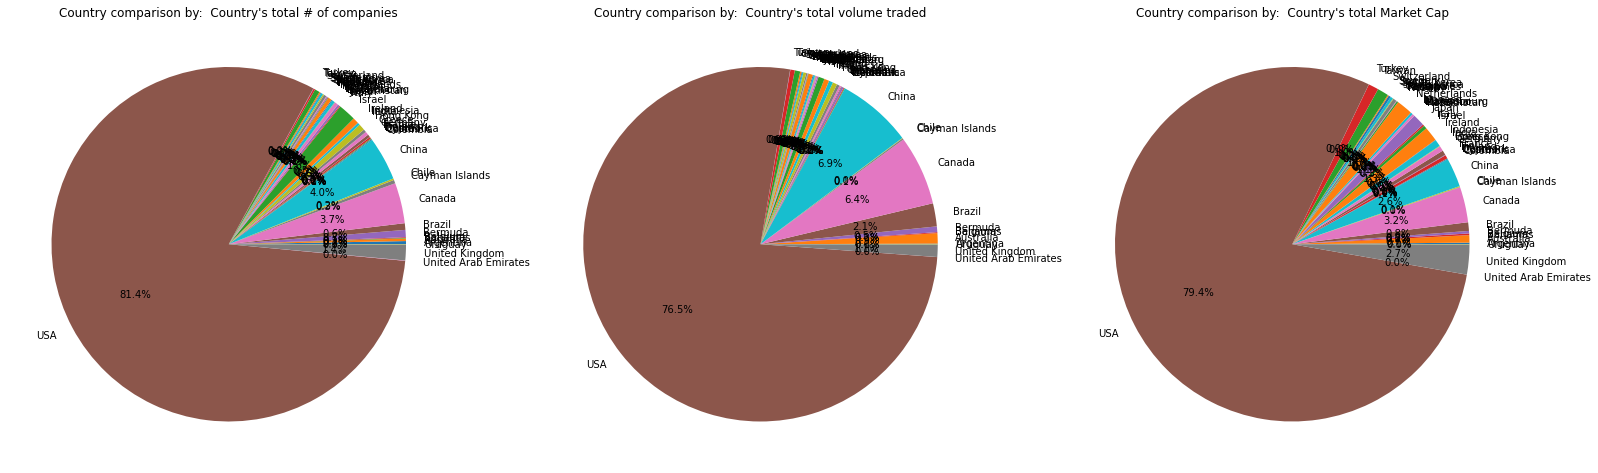

In [25]:
plt.figure(figsize=(27, 10))

plt.subplot(1, 3, 1)
plt.pie(
    group_country.ticker.count(),
    labels=group_country.ticker.count().index,
    autopct='%1.1f%%'
)
plt.title("Country comparison by:  Country's total # of companies")

plt.subplot(1, 3, 2)
plt.pie(
    group_country.volume.sum(),
    labels=group_country.volume.sum().index,
    autopct='%1.1f%%'
)
plt.title("Country comparison by:  Country's total volume traded")

plt.subplot(1, 3, 3)
plt.pie(
    group_country.market_cap.sum(),
    labels=group_country.market_cap.sum().index,
    autopct='%1.1f%%'
)
plt.title("Country comparison by:  Country's total Market Cap")

It's obvious that USA dominate the market. The leading countries are: USA, Canada, China

To get a better intuition, It's recommended to look at the data by region. To do so, we're going to add a column Region.

### Group Analysis: Region
> Since the major countries in the market are USA, Canda, and China, we separate these countries from other regions.

In [26]:
def find_region(row):
    regions = {
        'America': [
            'Uruguay', 'Peru', 'Panama',
            'Mexico', 'Costa Rica', 'Colombia',
            'Chile', 'Brazil', 'Bahamas',
            'Argentina',
        ],
        'Europe': [
            'Belgium', 'Bermuda', 'Cayman Islands',
            'Cyprus', 'Denmark', 'Finland',
            'France', 'Germany', 'Greece',
            'Ireland', 'Italy', 'Luxembourg',
            'Malta', 'Monaco', 'Netherlands',
            'Norway', 'Russia', 'Spain',
            'Sweden', 'Switzerland', 'Turkey',
            'United Kingdom',
        ],
        'Asia': [
            'Taiwan', 'South Korea', 'Singapore',
            'Philippines', 'Kazakhstan', 'Japan',
            'Indonesia', 'India', 'Hong Kong',
            'Israel', 'United Arab Emirates',
        ],
        'Other': [
            'Australia', 'New Zealand', 'South Africa'
        ],
        'USA': ['USA'],
        'Canada': ['Canada'],
        'China': ['China'],
    }
    for region in regions:
        if row['country'] in regions[region]:
            return region

In [27]:
stocks_df['region'] = stocks_df.apply(find_region, axis='columns')

In [28]:
group_region = stocks_df.groupby('region')

In [29]:
def show_part_region(part):
    plt.figure(figsize=(27, 10))
    colors = [
        'grey',
        'red',
        'green',
        'orange',
        'olive',
        'gold',
        'orchid',
        'steelblue',
        'mediumpurple',
        'teal',
        'pink',
    ]
    regs = [reg for reg in group_region.ticker.count().index]

    if part == 'Number of Companies':
        plt.subplot(1, 2, 1)
        plt.pie(
            group_region.ticker.count(),
            labels=group_region.ticker.count().index,
            autopct='%1.1f%%'
        )
        plt.title("Region comparison by:  Region's total # of companies")

        plt.subplot(1, 2, 2)
        plt.bar(
            np.arange(len(group_region.ticker.count())),
            group_region.ticker.count(),
            color=colors
        )
        plt.xticks(
            np.arange(len(group_region.ticker.count())),
            regs,
            rotation=90
        )
        plt.title("Region comparison by:  Region's total # of companies")

    elif part == 'Volume':
        plt.subplot(1, 2, 1)
        plt.pie(
            group_region.volume.sum(),
            labels=group_region.volume.sum().index,
            autopct='%1.1f%%'
        )
        plt.title("Region comparison by:  Region's total volume traded")

        plt.subplot(1, 2, 2)
        plt.bar(
            np.arange(len(group_region.volume.sum())),
            group_region.volume.sum(),
            color=colors
        )
        plt.xticks(
            np.arange(len(group_region.volume.sum())),
            regs,
            rotation=90
        )
        plt.title("Region comparison by:  Region's total volume traded")

    elif part == 'Market Cap':
        plt.subplot(1, 2, 1)
        plt.pie(
            group_region.market_cap.sum(),
            labels=group_region.market_cap.sum().index,
            autopct='%1.1f%%'
        )
        plt.title("Region comparison by:  Region's total Market Cap")

        plt.subplot(1, 2, 2)
        plt.bar(
            np.arange(len(group_region.market_cap.sum())),
            group_region.market_cap.sum(),
            color=colors
        )
        plt.xticks(
            np.arange(len(group_region.market_cap.sum())),
            regs,
            rotation=90
        )
        plt.title("Region comparison by:  Region's total Market Cap")

In [30]:
def show_chart_region(chart):
    plt.figure(figsize=(27, 10))
    colors = [
        'grey',
        'red',
        'green',
        'orange',
        'olive',
        'gold',
        'orchid',
        'steelblue',
        'mediumpurple',
        'teal',
        'pink',
    ]
    regs = [reg for reg in group_region.ticker.count().index]

    if chart == 'Pie Chart':
        plt.subplot(1, 3, 1)
        plt.pie(
            group_region.ticker.count(),
            labels=group_region.ticker.count().index,
            autopct='%1.1f%%'
        )
        plt.title("Region comparison by:  Region's total # of companies")

        plt.subplot(1, 3, 2)
        plt.pie(
            group_region.volume.sum(),
            labels=group_region.volume.sum().index,
            autopct='%1.1f%%'
        )
        plt.title("Region comparison by:  Region's total volume traded")

        plt.subplot(1, 3, 3)
        plt.pie(
            group_region.market_cap.sum(),
            labels=group_region.market_cap.sum().index,
            autopct='%1.1f%%'
        )
        plt.title("Region comparison by:  Region's total Market Cap")
    elif chart == 'Bar Chart':
        plt.subplot(1, 3, 1)
        plt.bar(
            np.arange(len(group_region.ticker.count())),
            group_region.ticker.count(),
            color=colors
        )
        plt.xticks(
            np.arange(len(group_region.ticker.count())),
            regs,
            rotation=90
        )
        plt.title("Region comparison by:  Region's total # of companies")

        plt.subplot(1, 3, 2)
        plt.bar(
            np.arange(len(group_region.volume.sum())),
            group_region.volume.sum(),
            color=colors
        )
        plt.xticks(
            np.arange(len(group_region.volume.sum())),
            regs,
            rotation=90
        )
        plt.title("Region comparison by:  Region's total volume traded")

        plt.subplot(1, 3, 3)
        plt.bar(
            np.arange(len(group_region.market_cap.sum())),
            group_region.market_cap.sum(),
            color=colors
        )
        plt.xticks(
            np.arange(len(group_region.market_cap.sum())),
            regs,
            rotation=90
        )
        plt.title("Region comparison by:  Region's total Market Cap")

In [31]:
part_region = interactive(
    show_part_region,
    part=['Number of Companies', 'Volume', 'Market Cap']
)
chart_region = interactive(
    show_chart_region,
    chart=['Pie Chart', 'Bar Chart']
)

tab_region = widgets.Tab()
tab_region.children = [part_region, chart_region]
for i, item in enumerate(['By Part', 'By Chart']):
    tab_region.set_title(i, item)
tab_region

Major things to consider from these plots are:
- Still ***USA*** dominate the market.
- Even tough ***Canadian*** companies traded with high volume, their market cap is not much.
- ***Europe*** and ***China*** act similar to each other but Europe has stronger impact both in volume and market cap.

## Group Analysis: Industry

In [32]:
group_industry = stocks_df.groupby(['sector', 'industry'])

Text(0.5, 1.3, 'Industry comparison grouprd by Sectors: total Market Cap')

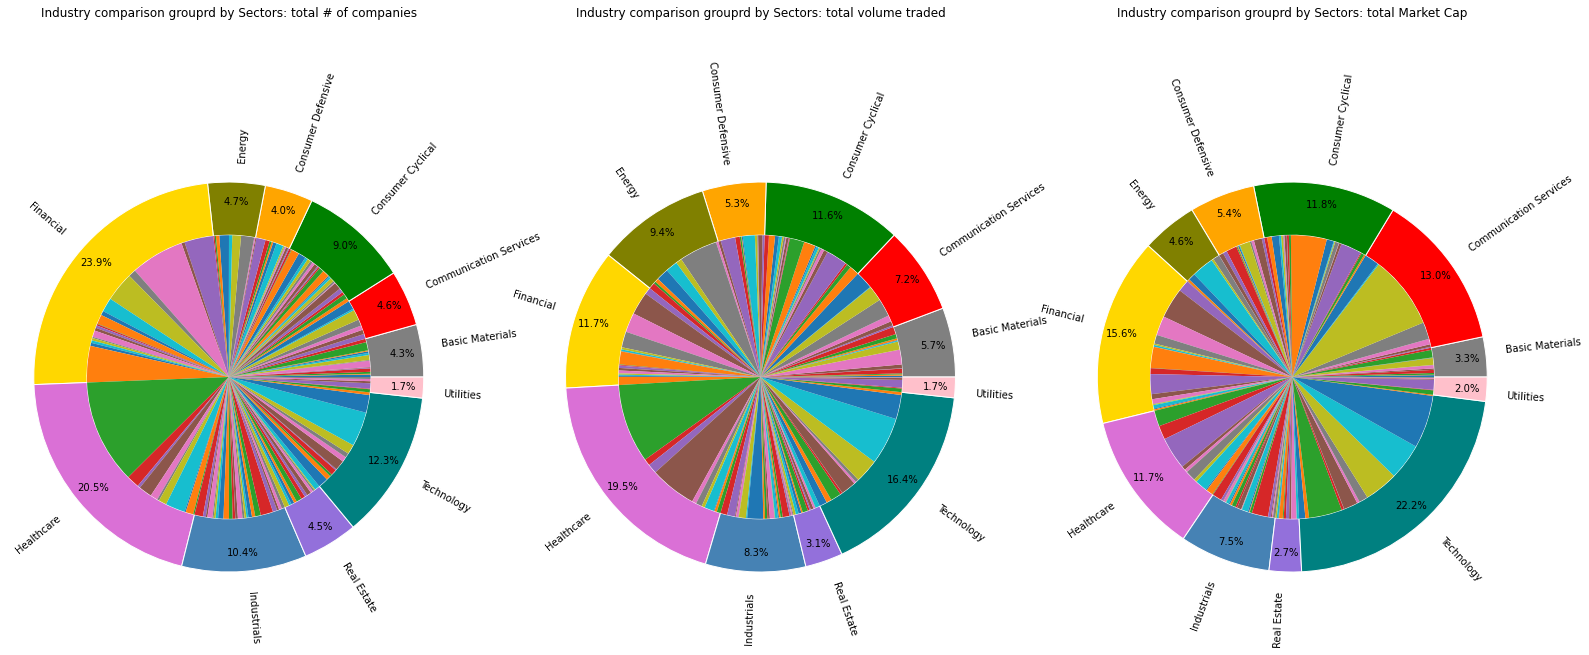

In [33]:
plt.figure(figsize=(27, 10))
colors = [
    'grey',
    'red',
    'green',
    'orange',
    'olive',
    'gold',
    'orchid',
    'steelblue',
    'mediumpurple',
    'teal',
    'pink'
]

plt.subplot(1, 3, 1)
plt.pie(
    group_sector.ticker.count(),
    labels=group_sector.ticker.count().index,
    colors=colors,
    wedgeprops={'width': 0.3, 'edgecolor': 'w'},
    radius=1.1,
    autopct='%1.1f%%',
    pctdistance=0.9,
    rotatelabels=True
)
plt.pie(
    group_industry.ticker.count(),
    radius=0.8
)
plt.title(
    "Industry comparison grouprd by Sectors: total # of companies",
    y=1.3
)

plt.subplot(1, 3, 2)
plt.pie(
    group_sector.volume.sum(),
    labels=group_sector.volume.sum().index,
    colors=colors,
    wedgeprops={'width': 0.3, 'edgecolor': 'w'},
    radius=1.1,
    autopct='%1.1f%%',
    pctdistance=0.9,
    rotatelabels=True
)
plt.pie(
    group_industry.volume.sum(),
    radius=0.8
)
plt.title(
    "Industry comparison grouprd by Sectors: total volume traded",
    y=1.3
)

plt.subplot(1, 3, 3)
plt.pie(
    group_sector.market_cap.sum(),
    labels=group_sector.market_cap.sum().index,
    colors=colors,
    wedgeprops={'width': 0.3, 'edgecolor': 'w'},
    radius=1.1,
    autopct='%1.1f%%',
    pctdistance=0.9,
    rotatelabels=True
)
plt.pie(
    group_industry.market_cap.sum(),
    radius=0.8
)
plt.title(
    "Industry comparison grouprd by Sectors: total Market Cap",
    y=1.3
)

- Industries with considerable number of companies:
    - Couple of industries in Financial sector
    - One industry in Technology sector
    - One industry in Healthcare sector

- Industries with considerable volume traded:
    - Two major industries in Healthcare sector
    - Two major industries in Consumer Cyclical sector
    - One industry in Technology sector
    - One industry in Basic Materails sector
    - Three major industries in Communication Services sector
    - One industry in Industrials sector

- Industries with considerable market cap: 
    - Couple of industries in Technology sector
    - One industry in Communication Services sector
    - One industry in Consumer Cyclical sector
    - One industry in Healthcare sector
---
### Let's look at the industries in each sector for more intuition.

In [34]:
def industry_tab_creator(sect):

    def show_part_industry(part):
        colors_industry = sns.color_palette('muted', n_colors=25)
        plt.figure(figsize=(27, 10))

        if part == 'Number of Companies':
            plt.subplot(1, 2, 1)
            plt.title(f'Industry comparison in sector " {sect} ": total # of companies')
            plt.pie(
                group_sector.get_group(sect).groupby('industry').ticker.count(),
                labels=group_sector.get_group(sect).groupby('industry').ticker.count().index,
                autopct='%1.1f%%',
                rotatelabels=True,
                colors=colors_industry
            )

            plt.subplot(1, 2, 2)
            plt.title(f'Industry comparison in sector " {sect} ": total # of companies')
            plt.bar(
                np.arange(len(group_sector.get_group(sect).groupby('industry').ticker.count())),
                group_sector.get_group(sect).groupby('industry').ticker.count(),
                color=colors_industry
            )
            plt.xticks(
                np.arange(len(group_sector.get_group(sect).groupby('industry').ticker.count())),
                group_sector.get_group(sect).groupby('industry').ticker.count().index,
                rotation=90
            )

        elif part == 'Volume':
            plt.subplot(1, 2, 1)
            plt.title(f'Industry comparison in sector " {sect} ": total volume traded')
            plt.pie(
                group_sector.get_group(sect).groupby('industry').volume.sum(),
                labels=group_sector.get_group(sect).groupby('industry').volume.sum().index,
                autopct='%1.1f%%',
                rotatelabels=True,
                colors=colors_industry
            )

            plt.subplot(1, 2, 2)
            plt.title(f'Industry comparison in sector " {sect} ": total volume traded')
            plt.bar(
                np.arange(len(group_sector.get_group(sect).groupby('industry').volume.sum())),
                group_sector.get_group(sect).groupby('industry').volume.sum(),
                color=colors_industry
            )
            plt.xticks(
                np.arange(len(group_sector.get_group(sect).groupby('industry').volume.sum())),
                group_sector.get_group(sect).groupby('industry').volume.sum().index,
                rotation=90
            )

        elif part == 'Market Cap':
            plt.subplot(1, 2, 1)
            plt.title(f'Industry comparison in sector " {sect} ": total Market Cap')
            plt.pie(
                group_sector.get_group(sect).groupby('industry').market_cap.sum(),
                labels=group_sector.get_group(sect).groupby('industry').market_cap.sum().index,
                autopct='%1.1f%%',
                rotatelabels=True,
                colors=colors_industry
            )

            plt.subplot(1, 2, 2)
            plt.title(f'Industry comparison in sector " {sect} ": total Market Cap')
            plt.bar(
                np.arange(len(group_sector.get_group(sect).groupby('industry').market_cap.sum())),
                group_sector.get_group(sect).groupby('industry').market_cap.sum(),
                color=colors_industry
            )
            plt.xticks(
                np.arange(len(group_sector.get_group(sect).groupby('industry').market_cap.sum())),
                group_sector.get_group(sect).groupby('industry').market_cap.sum().index,
                rotation=90
            )

    def show_chart_industry(chart):
        colors_industry = sns.color_palette('muted', n_colors=25)
        plt.figure(figsize=(27, 10))

        if chart == 'Pie Chart':
            plt.subplot(1, 3, 1)
            plt.title(f'Industry comparison in sector " {sect} ": total # of companies')
            plt.pie(
                group_sector.get_group(sect).groupby('industry').ticker.count(),
                labels=group_sector.get_group(sect).groupby('industry').ticker.count().index,
                autopct='%1.1f%%',
                rotatelabels=True,
                colors=colors_industry
            )

            plt.subplot(1, 3, 2)
            plt.title(f'Industry comparison in sector " {sect} ": total volume traded')
            plt.pie(
                group_sector.get_group(sect).groupby('industry').volume.sum(),
                labels=group_sector.get_group(sect).groupby('industry').volume.sum().index,
                autopct='%1.1f%%',
                rotatelabels=True,
                colors=colors_industry
            )

            plt.subplot(1, 3, 3)
            plt.title(f'Industry comparison in sector " {sect} ": total Market Cap')
            plt.pie(
                group_sector.get_group(sect).groupby('industry').market_cap.sum(),
                labels=group_sector.get_group(sect).groupby('industry').market_cap.sum().index,
                autopct='%1.1f%%',
                rotatelabels=True,
                colors=colors_industry
            )

        elif chart == 'Bar Chart':
            plt.subplot(1, 3, 1)
            plt.title(f'Industry comparison in sector " {sect} ": total # of companies')
            plt.bar(
                np.arange(len(group_sector.get_group(sect).groupby('industry').ticker.count())),
                group_sector.get_group(sect).groupby('industry').ticker.count(),
                color=colors_industry
            )
            plt.xticks(
                np.arange(len(group_sector.get_group(sect).groupby('industry').ticker.count())),
                group_sector.get_group(sect).groupby('industry').ticker.count().index,
                rotation=90
            )

            plt.subplot(1, 3, 2)
            plt.title(f'Industry comparison in sector " {sect} ": total volume traded')
            plt.bar(
                np.arange(len(group_sector.get_group(sect).groupby('industry').volume.sum())),
                group_sector.get_group(sect).groupby('industry').volume.sum(),
                color=colors_industry
            )
            plt.xticks(
                np.arange(len(group_sector.get_group(sect).groupby('industry').volume.sum())),
                group_sector.get_group(sect).groupby('industry').volume.sum().index,
                rotation=90
            )

            plt.subplot(1, 3, 3)
            plt.title(f'Industry comparison in sector " {sect} ": total Market Cap')
            plt.bar(
                np.arange(len(group_sector.get_group(sect).groupby('industry').market_cap.sum())),
                group_sector.get_group(sect).groupby('industry').market_cap.sum(),
                color=colors_industry
            )
            plt.xticks(
                np.arange(len(group_sector.get_group(sect).groupby('industry').market_cap.sum())),
                group_sector.get_group(sect).groupby('industry').market_cap.sum().index,
                rotation=90
            )

    part_industry = interactive(
        show_part_industry,
        part=['Number of Companies', 'Volume', 'Market Cap']
    )
    chart_industry = interactive(
        show_chart_industry,
        chart=['Pie Chart', 'Bar Chart']
    )

    tab_industry = widgets.Tab()
    tab_industry.children = [part_industry, chart_industry]
    for i, item in enumerate(['By Part', 'By Chart']):
        tab_industry.set_title(i, item)
    return tab_industry

In [35]:
secs = [sec for sec in group_sector.ticker.count().index]
accordion = widgets.Accordion(
    children=[industry_tab_creator(sec) for sec in secs]
)
for i in range(11):
    accordion.set_title(i, secs[i])
accordion

Accordion(children=(Tab(children=(interactive(children=(Dropdown(description='part', options=('Number of Compa…

---

# ETF (Exchange Traded Fund)

In [36]:
def etf_data(data: pd.DataFrame) -> pd.DataFrame:
    df = data[data['industry'] == 'Exchange Traded Fund'].reset_index()
    df.drop(
        ['No.', 'p/e', 'market_cap', 'country', 'industry', 'sector'],
        axis=1,
        inplace=True
    )
    df.dropna(subset=['price'], inplace=True)
    return df

In [37]:
etf_df = etf_data(df)

## ETF DataFrame after cleaning

In [38]:
etf_df.head(7)

,ticker,company,price,change,volume
0,AAAU,Goldman Sachs Physical Gold ETF,17.86,0.25,149479
1,AADR,AdvisorShares Dorsey Wright ADR ETF,65.36,1.07,2410
2,AAXJ,iShares MSCI All Country Asia ex Japan ETF,86.44,0.35,713219
3,ABEQ,Absolute Core Strategy ETF,27.65,1.07,398
4,ACES,ALPS Clean Energy ETF,70.71,-0.73,190079
5,ACIO,Aptus Collared Income Opportunity ETF,30.66,1.36,24114
6,ACT,"Enact Holdings, Inc.",21.32,2.75,573558


## Intuition

We need to look at the data and it's descriptive measurements to have some insight with the data we're dealing with.

In [39]:
etf_df.describe()

,price,change,volume
count,2045.000000,2045.000000,2.045000e+03
mean,56.329169,0.912386,7.279717e+05
std,53.215827,1.263835,3.783421e+06
min,2.250000,-8.910000,0.000000e+00
25%,27.170000,0.290000,5.236000e+03
50%,40.420000,1.040000,2.401600e+04
75%,65.060000,1.570000,1.736920e+05
max,743.870000,9.030000,8.923422e+07


### Let's take a look at correlation matrix:

<AxesSubplot:>

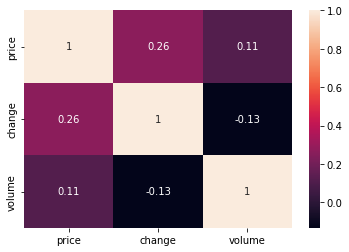

In [40]:
cor_etf = etf_df.corr()
sns.heatmap(
    cor_etf,
    xticklabels=cor_etf.columns,
    yticklabels=cor_etf.columns,
    annot=True
)

> No significant correlation found.

## Top movers

### Most traded ETFs

In [41]:
zs_vol = zscore(etf_df.volume)
volume_outliers = np.where(abs(zs_vol) > 3)[0]
most_traded_etfs = etf_df.loc[etf_df.index.intersection(volume_outliers)].sort_values(
    by=['volume'],
    ascending=False
).reset_index().drop(['index'], axis=1)

In [42]:
most_traded_etfs.head(10)

,ticker,company,price,change,volume
0,SQQQ,ProShares UltraPro Short QQQ,7.96,-5.58,89234216
1,SPY,SPDR S&P 500 ETF Trust,442.50,1.68,69943893
2,XLF,Financial Select Sector SPDR Fund,38.93,1.67,51210467
3,QQQ,Invesco QQQ Trust,366.63,1.84,43092278
4,VXX,iPath Series B S&P 500 VIX Short-Term Futures ETN,22.81,-5.51,31741925
5,UVXY,ProShares Ultra VIX Short-Term Futures ETF,18.16,-8.24,31658216
6,TQQQ,ProShares UltraPro QQQ,133.24,5.52,30175190
7,SLV,iShares Silver Trust,21.80,2.20,28913198
8,FXI,iShares China Large-Cap ETF,40.31,-0.47,26580386
9,HYG,iShares iBoxx $ High Yield Corporate Bond ETF,87.37,0.56,26150628


### Most percentage change

In [43]:
zs_change = zscore(etf_df.change)
change_outliers = np.where(abs(zs_change) > 4)[0]
most_percentage_change_etfs = etf_df.loc[etf_df.index.intersection(change_outliers)].sort_values(
    by=['change'],
    key=lambda col: abs(col),
    ascending=False
).reset_index().drop(['index'], axis=1)

In [44]:
most_percentage_change_etfs.head(10)

,ticker,company,price,change,volume
0,SOXL,Direxion Daily Semiconductor Bull 3X Shares,41.05,9.03,14585953
1,SOXS,Direxion Daily Semiconductor Bear 3X Shares,6.75,-8.91,12708495
2,UVXY,ProShares Ultra VIX Short-Term Futures ETF,18.16,-8.24,31658216
3,NAIL,Direxion Daily Homebuilders & Supplies Bull 3X...,75.50,7.93,604037
4,TECS,Direxion Daily Technology Bear 3X Shares,4.25,-6.80,2774250
5,TECL,Direxion Daily Technology Bull 3X Shares,62.53,6.71,1229285
6,USD,ProShares Ultra Semiconductors,35.76,6.14,228843
7,SSG,ProShares UltraShort Semiconductors,29.79,-6.12,8070
8,SQQQ,ProShares UltraPro Short QQQ,7.96,-5.58,89234216
9,VXX,iPath Series B S&P 500 VIX Short-Term Futures ETN,22.81,-5.51,31741925


### Most traded and most changed

In [45]:
both_outliers = sorted(list(set(volume_outliers).intersection(change_outliers)))
most_traded_and_most_changed_etfs = etf_df.loc[etf_df.index.intersection(both_outliers)].sort_values(
    by=['change'],
    ascending=False
).reset_index().drop(['index'], axis=1)

In [46]:
most_traded_and_most_changed_etfs.head(10)

,ticker,company,price,change,volume
0,SOXL,Direxion Daily Semiconductor Bull 3X Shares,41.05,9.03,14585953
1,VXX,iPath Series B S&P 500 VIX Short-Term Futures ETN,22.81,-5.51,31741925
2,SQQQ,ProShares UltraPro Short QQQ,7.96,-5.58,89234216
3,UVXY,ProShares Ultra VIX Short-Term Futures ETF,18.16,-8.24,31658216
4,SOXS,Direxion Daily Semiconductor Bear 3X Shares,6.75,-8.91,12708495
